In [24]:
# Install python-dotenv if not already installed
%pip install python-dotenv langgraph>=0.6.4 langchain-openai>0.3.29




Note: you may need to restart the kernel to use updated packages.


In [25]:
# Import required modules
from dotenv import load_dotenv
import os
# Load environment variables from .env file
load_dotenv()

# You can check if required environment variables are set
def validate_env_vars(required_vars):
    missing_vars = []
    for var in required_vars:
        if os.getenv(var) is None:
            missing_vars.append(var)
    return missing_vars

# List of required environment variables
required_vars = ['OPENAI_API_KEY', 'OPENAI_MODEL']

# Check for missing variables
missing = validate_env_vars(required_vars)
if missing:
    print(f"Warning: The following required environment variables are not set: {', '.join(missing)}")
else:
    print("All required environment variables are set!")

# You can also load environment variables from a specific file
from dotenv import load_dotenv, find_dotenv

# This will find the .env file automatically
env_file = find_dotenv()
print(f"\nFound .env file at: {env_file}")

# Reload environment variables (useful when .env file has changed)
load_dotenv(override=True)  # override=True will reload all variables


All required environment variables are set!

Found .env file at: c:\Users\rregi\Documents\GitHub\Code4Training\Week4\notebooks\.env


True

In [26]:
# Import required typing utilities for type hints and annotations
from typing import Annotated
from typing_extensions import TypedDict

# Import LangGraph components:
# - StateGraph: Main class for building the conversation flow
# - START: Special node marking the beginning of the graph
# - END: Special node marking the end of the graph
from langgraph.graph import StateGraph, START, END
# Import message handling utility
#https://langchain-ai.github.io/langgraph/reference/graphs/#graph-definitions
from langgraph.graph.message import add_messages


# Define the structure of our conversation state
class State(TypedDict):
    """
    Defines the structure of the state that flows through our conversation graph.
    
    The state contains:
    - messages: A list of conversation messages (both user and bot)
    
    The Annotated[list, add_messages] means:
    - The field is a list
    - When updating, use add_messages function to append new messages
    - This prevents overwriting previous messages, maintaining conversation history
    """
    messages: Annotated[list, add_messages]


# Initialize the graph builder with our State type
# This creates a directed graph where:
# - Nodes will be our processing steps (like the chatbot function)
# - Edges define how messages flow between nodes
# - The state (messages) flows through this graph structure
graph_builder = StateGraph(State)

# The graph will be used to:
# 1. Take user input (START)
# 2. Process it through our chatbot node
# 3. Return the response (END)

In [27]:
# Import the LangChain function to initialize chat models
from langchain.chat_models import init_chat_model

# Initialize the Large Language Model (LLM) for our chatbot
# Parameters explained:
# - "openai:gpt-4.1" specifies:
#   - Provider: OpenAI
#   - Model: GPT-4.1 (latest version)
# - This model will be used to generate responses in our chat application
# - The model requires an OPENAI_API_KEY to be set in the environment variables
#   (which we verified in the previous cell)
llm = init_chat_model("openai:gpt-4.1")



In [28]:
# Define the chatbot node function that processes messages in the graph
def chatbot(state: State):
    """
    This function defines how the chatbot processes messages in the LangGraph.
    
    Args:
        state (State): Contains the current conversation state with a 'messages' key
                      holding the list of all messages so far
    
    Returns:
        dict: Returns a new state with the bot's response added to messages
    """
    # llm.invoke() takes the current messages and generates a response
    # state["messages"] contains the conversation history
    # The response is wrapped in a list to maintain the message chain format
    return {"messages": [llm.invoke(state["messages"])]}

# Example of what this function does:
# Input state:  {"messages": [HumanMessage(content="Hello!")]}
# llm.invoke() generates response like: AIMessage(content="Hi! How can I help?")
# Output state: {"messages": [AIMessage(content="Hi! How can I help?")]}

In [29]:
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

Mermaid Syntax:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	chatbot(chatbot)
	__end__([<p>__end__</p>]):::last
	__start__ --> chatbot;
	chatbot --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc


Graph Visualization:


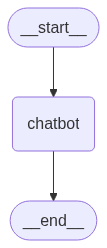

In [30]:
# Visualize the graph structure using LangGraph's built-in visualization
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# Get the Mermaid syntax
print("Mermaid Syntax:")
print(graph.get_graph().draw_mermaid())

# Display the graph as PNG
print("\nGraph Visualization:")
display(Image(graph.get_graph().draw_mermaid_png(
    curve_style=CurveStyle.LINEAR,
    node_colors=NodeStyles(
        first="#90EE90",  # Light green for start
        last="#FFB6C1",   # Light pink for end
        default="#ADD8E6"  # Light blue for other nodes
    ),
    wrap_label_n_words=9,
    background_color="white",
    padding=10
)))

In [31]:
# Example of how to use the graph with user input
from langchain_core.messages import HumanMessage, AIMessage

# Step 1: Start with empty state
empty_state = {
    "messages": []
}
print("1. Empty initial state:", empty_state)

# Step 2: First user message
first_user_input = "Hello, how are you?"
initial_state = {
    "messages": [HumanMessage(content=first_user_input)]
}
print("\n2. State after first user input:", initial_state)

# Step 3: Get bot's response to first message
first_result = graph.invoke(initial_state)

# Print the complete result to show the full state structure
# This includes:
# - The original user message (with metadata like ID)
# - The bot's response (with metadata like token usage, model info)
# - Additional metadata about the conversation
print("\nComplete state after bot response:")
print("- Contains both user and bot messages")
print("- Includes conversation metadata")
print("Raw state:", first_result)

# Print just the bot's response in a user-friendly format
# Breaking down first_result["messages"][-1].content:
# 1. first_result["messages"] - Gets the list of all messages
# 2. [-1] - Gets the last message in the list (negative index counts from end)
# 3. .content - Gets just the text content of that message
#
# Example structure:
# first_result = {
#     "messages": [
#         HumanMessage(content="Hello, how are you?"),  # index 0
#         AIMessage(content="Hi! How can I help?")      # index -1 (last)
#     ]
# }
print("\n3. First bot response:", first_result["messages"][-1].content)

# Let's also print each part to see how we get to the content:
print("\nBreaking down the steps:")
print("1. All messages:", first_result["messages"])  # Shows full message list
print("2. Last message:", first_result["messages"][-1])  # Shows last message with metadata
print("3. Just content:", first_result["messages"][-1].content)  # Shows just the text

# Step 4: Add second user message
# Note: We need to include the previous messages to maintain conversation history
second_user_input = "What can you help me with?"
second_state = {
    "messages": first_result["messages"] + [HumanMessage(content=second_user_input)]
}
print("\n4. State after adding second user message:")
print("- Previous bot response remains in history")
print("- New user message added")
for idx, msg in enumerate(second_state["messages"]):
    print(f"Message {idx + 1}: {'User' if isinstance(msg, HumanMessage) else 'Bot'} - {msg.content}")

# Step 5: Get bot's response to second message
second_result = graph.invoke(second_state)
print("\n5. Second bot response:", second_result["messages"][-1].content)

# Step 6: Show final conversation state
print("\n6. Final conversation state:")
for idx, msg in enumerate(second_result["messages"]):
    print(f"Message {idx + 1}: {'User' if isinstance(msg, HumanMessage) else 'Bot'} - {msg.content}")


1. Empty initial state: {'messages': []}

2. State after first user input: {'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={})]}

Complete state after bot response:
- Contains both user and bot messages
- Includes conversation metadata
Raw state: {'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='1e1b1429-9745-4dc8-9e13-da01e68731a6'), AIMessage(content="Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 13, 'total_tokens': 42, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_799e4ca

In [32]:
# Basic LangGraph Chatbot
# CONVERSATION WITH A BOT
# Maintains conversation in memory
# Import ipywidgets for interactive input
from ipywidgets import widgets
from IPython.display import display, clear_output
from langchain_core.messages import HumanMessage, AIMessage

# Create widgets for the chat interface
text_input = widgets.Text(
    value='',
    placeholder='Type your message here...',
    description='Input:',
    layout={'width': '500px'}
)
send_button = widgets.Button(
    description='Send',
    button_style='primary',
    layout={'width': '100px'}
)
output = widgets.Output()

messages = []

def on_send_button_clicked(b):
    with output:
        # clear_output()
        # Get the input text
        user_input = text_input.value
        if not user_input.strip():  # Skip empty messages
            return
            
        # Clear the input field
        text_input.value = ''
        
        # Add user message to the state
        messages.append(HumanMessage(content=user_input))
        
        # Display user message
        print(f"You: {user_input}")
        
        # Run the graph
        result = graph.invoke({"messages": messages})
        
        # Get the latest response and add it to messages
        bot_response = result["messages"][-1].content
        messages.append(AIMessage(content=bot_response))
        
        # Display bot response
        print(f"\nBot: {bot_response}")

# Connect the button click to the handler
send_button.on_click(on_send_button_clicked)

# Display the chat interface
display(widgets.VBox([
    widgets.HBox([text_input, send_button]),
    output
]))
